In [1]:
import datetime
from dateutil.parser import parse

import getpass

from IPython.core.display import display, HTML

import numpy as np
from pandas import pandas
pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.width', None)
pandas.set_option('display.max_colwidth', None)

from storyboardclient.v1 import client
api_url="https://storyboard.openstack.org/api/v1"

#display(HTML('Get a token from: <a href="https://storyboard.openstack.org/#!/profile/tokens">https://storyboard.openstack.org/#!/profile/tokens</a></body>'))
print('https://storyboard.openstack.org/#!/profile/tokens')
access_token = getpass.getpass('Enter token:')

storyboard = client.Client(api_url, access_token)

https://storyboard.openstack.org/#!/profile/tokens


Enter token: ····································


In [2]:
%%time

# Get all stories
stories = storyboard.stories.get_all()
print('Number of stories', len(stories))

# Get all tasks
tasks = storyboard.tasks.get_all()
print('Number of tasks', len(tasks))

# get all users
users = storyboard.users.get_all()
print('Number of users', len(users))

Number of stories 27873
Number of tasks 38368
Number of users 6769
CPU times: user 4.51 s, sys: 292 ms, total: 4.81 s
Wall time: 1min 45s


In [14]:
# Create dicts for stories, tasks and users
users_dict = {}
for u in users:
    users_dict[u.id] = u.to_dict() 

stories_dict = {}
stories_objects_dict = {}
for s in stories:
    stories_dict[s.id] = s.to_dict()
    stories_objects_dict[s.id] = s
    if s.creator_id is None:
        stories_dict[s.id]['creator_name'] = 'UNKNOWN'
    else:
        stories_dict[s.id]['creator_name'] = users_dict[s.creator_id]['full_name']

tasks_dict = {}
for t in tasks:
    tasks_dict[t.id] = t.to_dict()
    if t.creator_id is None:
        tasks_dict[t.id]['creator_name'] = stories_dict[t.story_id]['creator_name']
    else:
        tasks_dict[t.id]['creator_name'] = users_dict[t.creator_id]['full_name']
    if t.assignee_id is None:
        tasks_dict[t.id]['assignee_name'] = 'UNKNOWN'
    else:
        tasks_dict[t.id]['assignee_name'] = users_dict[t.assignee_id]['full_name']
    tasks_dict[t.id]['story_updated_at'] = stories_dict[t.story_id]['updated_at']
    tasks_dict[t.id]['story_url'] = 'https://storyboard.openstack.org/#!/story/' + str(t.story_id)

In [15]:
#stories_dict[2006738]

In [16]:
#tasks_dict[1]

In [17]:
# Get the project group to work with
project_group_name = 'magnum'

project_group = storyboard.project_groups.find(name=project_group_name)

project_ids = [ project.id for project in project_group.projects.list() ]
project_names = [ project.name for project in project_group.projects.list() ]
projects = {}
for project in project_group.projects.list():
    projects[project.id] = project.name


In [49]:
def histogram_of_tasks(tasks):
    task_counts = {}
    for pn in project_names:
        task_counts[pn] = {}
    for t in tasks_in_group:
        project_name = projects[t['project_id']]
        task_counts[project_name][t['status']] = task_counts[project_name].get(t['status'], 0) + 1
    return task_counts

def print_task_with_url_html(task_id):
    task = tasks_dict[task_id]
    story_id = tasks_dict[task_id]['story_id']
    story_title = stories_dict[story_id]['title']
    msg = str(task_id)
    msg += ' <a href="https://storyboard.openstack.org/#!/story/'
    msg += str(story_id) + '">' + story_title + '</a></body>'
    display(HTML(msg))

def print_task_with_url(task_id):
    task = tasks_dict[task_id]
    story_id = tasks_dict[task_id]['story_id']
    story_title = stories_dict[story_id]['title']
    story_updated = stories_dict[story_id]['updated_at']
    msg = str(task_id) + ' ' + ' https://storyboard.openstack.org/#!/story/' + str(story_id) + ' ' + story_title
    print(msg)

def print_story_with_url(story_id):
    story_title = stories_dict[story_id]['title']
    msg = str(story_id)
    msg += ' <a href="https://storyboard.openstack.org/#!/story/'
    msg += str(story_id) + '">' + story_title + '</a></body>'
    display(HTML(msg))
    
def is_task_open(id):
    if tasks_dict[id]['status'] not in ['invalid', 'merged']:
        return True
    else:
        return False

def is_task_open_now(task):
    if task.status not in ['invalid', 'merged']:
        return True
    else:
        return False

def days_since_updated(id):
    if id in stories_dict:
        story_id = id
    else:
        story_id = tasks_dict[id]['story_id']

    updated_at = parse(stories_dict[story_id]['updated_at']).replace(tzinfo=None)
    now = datetime.datetime.now().replace(tzinfo=None)
    delta = now - updated_at
    return delta.days

def comment_story_for_invalid_task(task_id):
    t = tasks_dict[task_id]
    s = stories_objects_dict[t['story_id']]
    msg =   'This is an automated message.'
    msg += ' This story has not been updated in the last 360 days.'
    msg += ' Per discussion on the magnum meeting of 2020-05-13, we marks task:'
    msg += ' ' + str(task_id)
    msg += ' as invalid.'
    msg += 'Feel free to mark as todo any task in this story or add new ones.'
    msg += ' http://eavesdrop.openstack.org/meetings/magnum/2020/magnum.2020-05-13-09.00.log.html#l-44'
    s.comments.create(content=msg)


def mark_task_invalid(task_id):
    task = storyboard.tasks.get(task_id)
    if is_task_open_now(task):
        storyboard.tasks.update(id=task_id, status='invalid')
        comment_story_for_invalid_task(task_id)
        print(task_id, 'is marked as invalid')
    else:
        print(task_id, 'is already invalid')

In [50]:
# Get all tasks affecting the above project group
tasks_in_group = []
tasks_in_group_dict = {}

for t in tasks:
    if t.project_id in project_ids:
        tasks_in_group.append(tasks_dict[t.id])
        tasks_in_group_dict[t.id] = tasks_dict[t.id]
print('all tasks:', len(tasks_in_group))

open_tasks_in_group = []
open_tasks_in_group_dict = {}
for t in tasks_in_group:
    if is_task_open(t['id']):
        open_tasks_in_group.append(t)
        open_tasks_in_group_dict[t['id']] = t
print('open tasks:', len(open_tasks_in_group))

all tasks: 2397
open tasks: 389


Active   tasks not updated in the last 360 days: 284
Active Stories not updated in the last 360 days: 277


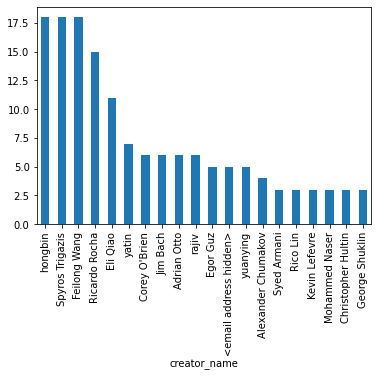

In [51]:
tasks_to_close = {}
days_since_updated_th = 360
active_stories = {}
for id, t in open_tasks_in_group_dict.items():
    if days_since_updated(id) > days_since_updated_th:
        tasks_to_close[id] = t
        active_stories[t['story_id']] = stories_dict[t['story_id']]
print('Active   tasks not updated in the last', days_since_updated_th, 'days:', len(tasks_to_close.keys()))
print('Active Stories not updated in the last', days_since_updated_th, 'days:', len(active_stories.keys()))

df = pandas.DataFrame.from_dict(active_stories, orient='index')
df_grouped = df.groupby(['creator_name'])['id'].count()
df2 = df_grouped.sort_values(ascending=False)
df2.head(20).plot.bar()

In [52]:
#df2

In [53]:
%%time
mark_task_invalid(20138)

20138 is already invalid
CPU times: user 16.3 ms, sys: 972 µs, total: 17.3 ms
Wall time: 552 ms


In [54]:
%%time

for task_id, t in tasks_to_close.items():
    mark_task_invalid(task_id)

20117 is already invalid
20138 is already invalid
20159 is marked as invalid
20192 is marked as invalid
20207 is marked as invalid
20209 is marked as invalid
20216 is marked as invalid
20244 is marked as invalid
20247 is marked as invalid
20276 is marked as invalid
20277 is marked as invalid
20279 is marked as invalid
20280 is marked as invalid
20281 is marked as invalid
20282 is marked as invalid
20284 is marked as invalid
20290 is marked as invalid
20296 is marked as invalid
20297 is marked as invalid
20299 is marked as invalid
20303 is marked as invalid
20304 is marked as invalid
20307 is marked as invalid
20312 is marked as invalid
20314 is marked as invalid
20320 is marked as invalid
20321 is marked as invalid
20322 is marked as invalid
20325 is marked as invalid
20326 is marked as invalid
20331 is marked as invalid
20332 is marked as invalid
20335 is marked as invalid
20338 is marked as invalid
20339 is marked as invalid
20372 is marked as invalid
20373 is marked as invalid
20378

In [55]:
%%time

# Get all stories
stories = storyboard.stories.get_all()
print('Number of stories', len(stories))

# Get all tasks
tasks = storyboard.tasks.get_all()
print('Number of tasks', len(tasks))

# get all users
users = storyboard.users.get_all()
print('Number of users', len(users))

Number of stories 27875
Number of tasks 38370
Number of users 6769
CPU times: user 4.51 s, sys: 295 ms, total: 4.8 s
Wall time: 1min 37s


all tasks: 2397
open tasks: 103
Active   tasks 103
Active stories 67


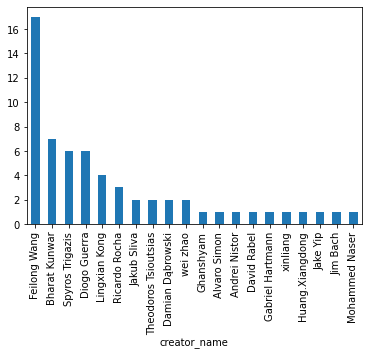

In [61]:
# Create dicts for stories, tasks and users
users_dict = {}
for u in users:
    users_dict[u.id] = u.to_dict() 

stories_dict = {}
stories_objects_dict = {}
for s in stories:
    stories_dict[s.id] = s.to_dict()
    stories_objects_dict[s.id] = s
    if s.creator_id is None:
        stories_dict[s.id]['creator_name'] = 'UNKNOWN'
    else:
        stories_dict[s.id]['creator_name'] = users_dict[s.creator_id]['full_name']

tasks_dict = {}
for t in tasks:
    tasks_dict[t.id] = t.to_dict()
    if t.creator_id is None:
        tasks_dict[t.id]['creator_name'] = stories_dict[t.story_id]['creator_name']
    else:
        tasks_dict[t.id]['creator_name'] = users_dict[t.creator_id]['full_name']
    if t.assignee_id is None:
        tasks_dict[t.id]['assignee_name'] = 'UNKNOWN'
    else:
        tasks_dict[t.id]['assignee_name'] = users_dict[t.assignee_id]['full_name']
    tasks_dict[t.id]['story_updated_at'] = stories_dict[t.story_id]['updated_at']
    tasks_dict[t.id]['story_url'] = 'https://storyboard.openstack.org/#!/story/' + str(t.story_id)
    
# Get the project group to work with
project_group_name = 'magnum'

project_group = storyboard.project_groups.find(name=project_group_name)

project_ids = [ project.id for project in project_group.projects.list() ]
project_names = [ project.name for project in project_group.projects.list() ]
projects = {}
for project in project_group.projects.list():
    projects[project.id] = project.name

# Get all tasks affecting the above project group
tasks_in_group = []
tasks_in_group_dict = {}

for t in tasks:
    if t.project_id in project_ids:
        tasks_in_group.append(tasks_dict[t.id])
        tasks_in_group_dict[t.id] = tasks_dict[t.id]
print('all tasks:', len(tasks_in_group))

open_tasks_in_group = []
open_tasks_in_group_dict = {}
for t in tasks_in_group:
    if is_task_open(t['id']):
        open_tasks_in_group.append(t)
        open_tasks_in_group_dict[t['id']] = t
print('open tasks:', len(open_tasks_in_group))

tasks_to_close = {}
days_since_updated_th = 360
active_stories = {}
for id, t in open_tasks_in_group_dict.items():
    tasks_to_close[id] = t
    active_stories[t['story_id']] = stories_dict[t['story_id']]
print('Active   tasks', len(tasks_to_close.keys()))
print('Active stories', len(active_stories.keys()))

df = pandas.DataFrame.from_dict(active_stories, orient='index')
df_grouped = df.groupby(['creator_name'])['id'].count()
df2 = df_grouped.sort_values(ascending=False)
df2.head(20).plot.bar()